# Drug Spending Analysis and Predictive Decision Support Using Medicaid Utilization Data

## Business Understanding.

Medicaid spends millions of dollars each year on prescription drugs for patients across the United States, and this expenditure has been steadily increasing, making it challenging for administrators and policymakers to monitor and control costs effectively. Current reporting systems mainly focus on past spending and fail to provide accurate forecasts or actionable insights for future decision-making. This hybrid project aims to address these challenges by combining data analytics and predictive modeling to both analyze historical Medicaid drug utilization patterns and forecast future expenditures. By identifying high-cost drugs, overutilized prescriptions, and spending variations across states and drug categories, the project seeks to provide a comprehensive understanding of where resources are being used and how they can be optimized. Furthermore, predictive insights will allow stakeholders to anticipate spending trends, plan budgets proactively, and implement cost-saving strategies such as promoting generic alternatives or managing overprescription. Ultimately, the project intends to transform large volumes of Medicaid drug data into a decision-support tool that empowers administrators, policymakers, and healthcare stakeholders to make informed, data-driven decisions that improve efficiency, reduce unnecessary costs, and ensure sustainable management of Medicaid drug spending.

## Problem Statement.

Healthcare programs such as Medicaid spend large amounts of money on prescription drugs each year. Monitoring and controlling this spending is important for budgeting, policy planning, and ensuring efficient allocation of resources. However, the large volume of drug utilization data makes it difficult to quickly identify spending patterns, high-cost drugs, and trends in reimbursement.

Existing reporting systems mainly focus on describing past expenditures but do not effectively support prediction of future spending or early identification of cost drivers. This limits the ability of decision makers to plan budgets and implement cost-control measures proactively.

This project aims to analyze Medicaid drug utilization data to identify key spending patterns and build a machine learning model capable of predicting drug reimbursement spending based on utilization metrics. In addition, a simple web-based tool will be developed to demonstrate how such predictions could support planning and decision making.

Although the dataset is limited to two quarters of data from one year, the project demonstrates a proof-of-concept approach that can be extended when more historical data becomes available.


## Objectives.
### General Objective
To analyze drug utilization patterns and develop a predictive model for estimating reimbursement spending using Medicaid drug utilization data.

### Specific Objectives
1. Which are the most expensive drugs?
2. Which are the most popular drugs?
3. How does drug use and spending differ between states?
4. How to save money or make better decisions about Medicaid spending?

## Data Understanding.

The project uses Medicaid drug utilization data from multiple states, including columns such as Product Name, Units Reimbursed, Number of Prescriptions, Total Amount Reimbursed, Medicaid Amount Reimbursed, State, and Quarter. The dataset contains numerical, categorical, and time-related information, enabling both analysis and predictive modeling. Data quality checks are necessary to address missing values, duplicates, and inconsistencies. Initial exploration will identify high-cost drugs, top-spending states, and spending trends. Some limitations include incomplete data, inconsistent naming, and missing rebate details. Data preparation will involve standardizing names, aggregating by state and quarter, and engineering features like cost per unit and drug type, ensuring the data is ready for accurate analysis and forecasting.


In [227]:
import pandas as pd
import numpy as np

In [228]:
df = pd.read_csv("../data/Medicaid_data.csv")
df.head()

,Utilization Type,State,NDC,Labeler Code,Product Code,Package Size,Year,Quarter,Suppression Used,Product Name,Units Reimbursed,Number of Prescriptions,Total Amount Reimbursed,Medicaid Amount Reimbursed,Non Medicaid Amount Reimbursed
0,FFSU,AK,2143380,2,1433,80,2025,2,False,TRULICITY,216.0,107.0,102976.40,98630.87,4345.53
1,FFSU,AK,2143480,2,1434,80,2025,2,False,TRULICITY,218.0,109.0,104481.92,101806.64,2675.28
2,FFSU,AK,2143611,2,1436,11,2025,2,False,EMGALITY P,21.0,20.0,15227.25,15227.25,0.00
3,FFSU,AK,2144511,2,1445,11,2025,2,False,TALTZ AUTO,33.0,30.0,231532.28,231532.28,0.00
4,FFSU,AK,2145780,2,1457,80,2025,2,False,MOUNJARO,208.0,104.0,108908.80,105953.32,2955.48


In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313397 entries, 0 to 1313396
Data columns (total 15 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Utilization Type                1313397 non-null  object 
 1   State                           1313397 non-null  object 
 2   NDC                             1313397 non-null  int64  
 3   Labeler Code                    1313397 non-null  int64  
 4   Product Code                    1313397 non-null  int64  
 5   Package Size                    1313397 non-null  int64  
 6   Year                            1313397 non-null  int64  
 7   Quarter                         1313397 non-null  int64  
 8   Suppression Used                1313397 non-null  bool   
 9   Product Name                    1313397 non-null  object 
 10  Units Reimbursed                1313397 non-null  float64
 11  Number of Prescriptions         1313397 non-null  float64
 12  

In [230]:
df.isna().sum()

Utilization Type                  0
State                             0
NDC                               0
Labeler Code                      0
Product Code                      0
Package Size                      0
Year                              0
Quarter                           0
Suppression Used                  0
Product Name                      0
Units Reimbursed                  0
Number of Prescriptions           0
Total Amount Reimbursed           0
Medicaid Amount Reimbursed        0
Non Medicaid Amount Reimbursed    0
dtype: int64

In [231]:
df.duplicated().value_counts()

False    1313397
Name: count, dtype: int64

## Checking for outliers using Interquatile Range 

In [232]:
# Select your target column
column = "Total Amount Reimbursed"

# Calculate Q1 and Q3
Q1 = df[column].quantile(0.25)
Q3 = df[column].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)
print("Number of Outliers:", outliers.shape[0])
print("Percentage of Outliers:", (outliers.shape[0] / df.shape[0]) * 100)

Lower Bound: -9221.155
Upper Bound: 16410.325
Number of Outliers: 210679
Percentage of Outliers: 16.040770612389093


Top 10 most expensive drugs reimburbed by medicaid 

In [233]:
outliers[["Product Name", "Total Amount Reimbursed"]].sort_values(
    by="Total Amount Reimbursed", ascending=False
).head(10)


,Product Name,Total Amount Reimbursed
735981,Biktarvy,4.515656e+08
676260,Biktarvy,4.488801e+08
676261,Biktarvy,3.710330e+08
735982,Biktarvy,3.689492e+08
700544,HUMIRA PEN,3.524114e+08
640995,HUMIRA PEN,3.140778e+08
640028,DUPIXENT S,2.733216e+08
700543,HUMIRA PEN,2.716228e+08
699541,DUPIXENT S,2.558185e+08
640994,HUMIRA PEN,2.522763e+08


standardizing the product names so that the same drug written in slightly different ways is treated as one value.This makes sure we have the exact number of drugs without double counting due to typing errors.

In [234]:
import re


df["Product Name_raw"] = df["Product Name"]

def clean_product_name(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip()                 
    x = re.sub(r"\s+", " ", x)        
    x = x.casefold()                   
    return x

df["Product Name"] = df["Product Name"].apply(clean_product_name)

In [235]:
# Remove the national/suppressed "XX" row
df = df[df['State'] != 'XX'].copy()
print("Dataset shape after removing XX:", df.shape)
print("Remaining states:", sorted(df['State'].unique()))

Dataset shape after removing XX: (1194315, 16)
Remaining states: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


In [236]:
df.columns

Index(['Utilization Type', 'State', 'NDC', 'Labeler Code', 'Product Code',
       'Package Size', 'Year', 'Quarter', 'Suppression Used', 'Product Name',
       'Units Reimbursed', 'Number of Prescriptions',
       'Total Amount Reimbursed', 'Medicaid Amount Reimbursed',
       'Non Medicaid Amount Reimbursed', 'Product Name_raw'],
      dtype='object')

In [237]:
df["Product Name_raw"] = df["Product Name"]
df.drop(columns=["Product Name_raw"], inplace=True, errors="ignore")

In [238]:
df.columns

Index(['Utilization Type', 'State', 'NDC', 'Labeler Code', 'Product Code',
       'Package Size', 'Year', 'Quarter', 'Suppression Used', 'Product Name',
       'Units Reimbursed', 'Number of Prescriptions',
       'Total Amount Reimbursed', 'Medicaid Amount Reimbursed',
       'Non Medicaid Amount Reimbursed'],
      dtype='object')

Filtering the top 300 drugs that drive spending. Classifying them to filtered rows from the original rows from the dataset.

In [239]:
top_drugs = (
    df.groupby("Product Name")["Total Amount Reimbursed"]
      .sum()
      .sort_values(ascending=False)
      .head(300)
      .index
)

df_filtered = df[df["Product Name"].isin(top_drugs)].copy()

print("Original rows:", len(df))
print("Filtered rows:", len(df_filtered))
print("Unique drugs after filter:", df_filtered["Product Name"].nunique())

Original rows: 1194315
Filtered rows: 261177
Unique drugs after filter: 300


Calculating the percentage of spending retained after filtering to checking if filtering was appropriate or was too aggressive leading to loss of spending data to be used in modelling.

In [240]:
original_total = df["Total Amount Reimbursed"].sum()
filtered_total = df_filtered["Total Amount Reimbursed"].sum()

print("Spending retained (%):", (filtered_total / original_total) * 100)


Spending retained (%): 69.30136929521737


The percentage retained is 69%. Above 90% is excellenet data retention that can be used for modelling, 70 - 90% is acceptable since the model can learn from trained data  and forecast properly while below 70% might indicate filtering was too aggressive.

We can use a better approach to select the unique drugs driving spending. Instead of limiting our selection to a specified number of drugs like 300, we can keep drugs that account for 80-90% of spending. This is known as cumulative spending threshold.

In [241]:
drug_spending = (
    df.groupby("Product Name")["Total Amount Reimbursed"]
      .sum()
      .sort_values(ascending=False)
)

cumulative_spending = drug_spending.cumsum() / drug_spending.sum()

top_drugs = cumulative_spending[cumulative_spending <= 0.85].index  # 85% threshold

df_filtered = df[df["Product Name"].isin(top_drugs)].copy()

print("Unique drugs kept:", len(top_drugs))


Unique drugs kept: 683


Now it is visible that our unique drug number has increased from 300 to 683, which is more than double the number. Now we have a high number of high spending drugs to aid in prediction.

In [242]:
df.shape

(1194315, 15)

In [243]:
df_filtered.shape

(641224, 15)

In [244]:
df_filtered.columns

Index(['Utilization Type', 'State', 'NDC', 'Labeler Code', 'Product Code',
       'Package Size', 'Year', 'Quarter', 'Suppression Used', 'Product Name',
       'Units Reimbursed', 'Number of Prescriptions',
       'Total Amount Reimbursed', 'Medicaid Amount Reimbursed',
       'Non Medicaid Amount Reimbursed'],
      dtype='object')

## Most expensive drugs in the market 

In [245]:
top_15_drugs = (
    df_filtered.groupby("Product Name")["Total Amount Reimbursed"]
      .sum()
      .sort_values(ascending=False)
      .head(15)
)
top_15_drugs.head(15)


Product Name
biktarvy      1.487752e+09
jardiance     1.224935e+09
trulicity     9.942157e+08
invega sus    8.841717e+08
humira(cf)    8.621136e+08
humira pen    7.755576e+08
ozempic       6.612600e+08
dupixent s    6.432030e+08
eliquis       6.114578e+08
zepbound      5.080595e+08
dupixent p    4.911089e+08
ozempic 0.    4.176484e+08
abilify ma    4.130071e+08
stelara 90    3.995239e+08
vraylar (c    3.830521e+08
Name: Total Amount Reimbursed, dtype: float64

In [246]:
# Changing the series to a dataframe
most_exp_drugs = top_15_drugs.reset_index()

# Rename columns for the new Dataframe
most_exp_drugs.columns = ["Product Name", "Total Amount Reimbursed"]
most_exp_drugs

,Product Name,Total Amount Reimbursed
0,biktarvy,1.487752e+09
1,jardiance,1.224935e+09
2,trulicity,9.942157e+08
3,invega sus,8.841717e+08
4,humira(cf),8.621136e+08
5,humira pen,7.755576e+08
6,ozempic,6.612600e+08
7,dupixent s,6.432030e+08
8,eliquis,6.114578e+08
9,zepbound,5.080595e+08


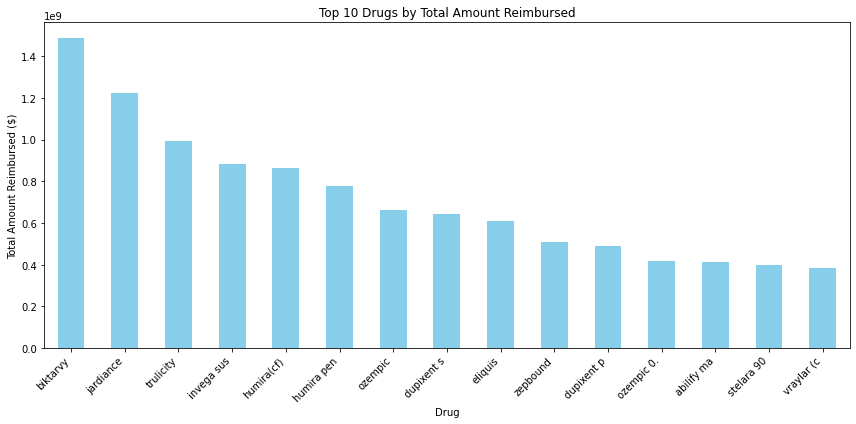

In [247]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
top_15_drugs.plot(kind='bar', color='skyblue')
plt.title("Top 10 Drugs by Total Amount Reimbursed")
plt.ylabel("Total Amount Reimbursed ($)")
plt.xlabel("Drug")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

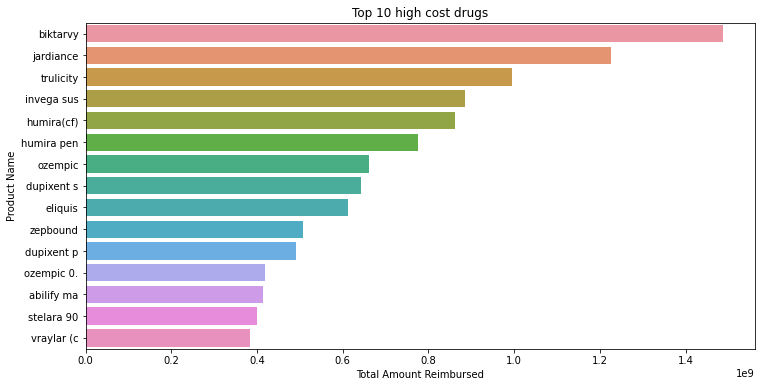

In [248]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(data=most_exp_drugs, x="Total Amount Reimbursed", y="Product Name")
plt.title('Top 10 high cost drugs')
plt.xlabel("Total Amount Reimbursed")
plt.ylabel('Product Name')
plt.show()

## Most popular/common drugs as per presciptions

In [249]:
# Filtering the most popular drugs 
common_drugs = (
    df_filtered.groupby("Product Name")["Number of Prescriptions"]
      .sum()
      .sort_values(ascending=False)
      .head(15)
)
common_drugs.head(15)


Product Name
amoxicilli    8243538.0
albuterol     7264826.0
ibuprofen     6543001.0
fluticason    6042960.0
atorvastat    5987791.0
gabapentin    5969243.0
ondansetro    5741383.0
cetirizine    5275403.0
metformin     4655398.0
sertraline    4481159.0
hydroxyzin    4438048.0
omeprazole    4397245.0
amlodipine    4231409.0
lisinopril    4016472.0
trazodone     3957128.0
Name: Number of Prescriptions, dtype: float64

In [250]:
# Changing into a dataframe
popular_drugs = common_drugs.reset_index()
popular_drugs.columns = ["Product Name", "No of prescriptions"]
popular_drugs

,Product Name,No of prescriptions
0,amoxicilli,8243538.0
1,albuterol,7264826.0
2,ibuprofen,6543001.0
3,fluticason,6042960.0
4,atorvastat,5987791.0
5,gabapentin,5969243.0
6,ondansetro,5741383.0
7,cetirizine,5275403.0
8,metformin,4655398.0
9,sertraline,4481159.0


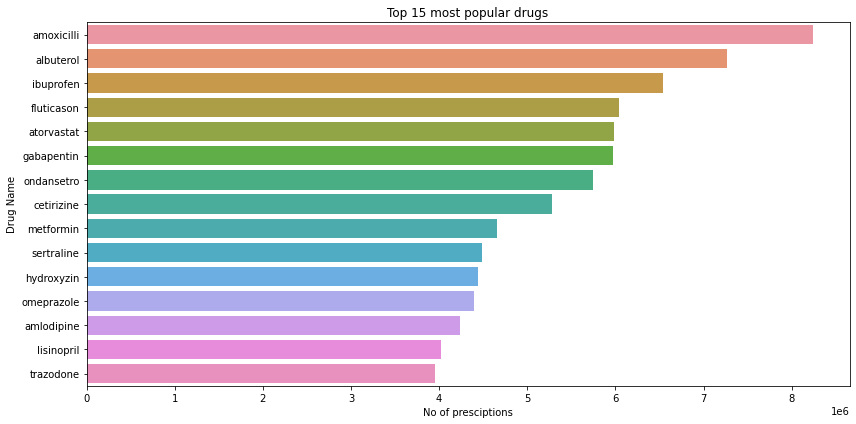

In [251]:
plt.figure(figsize=(12,6))
sns.barplot(data=popular_drugs, x="No of prescriptions", y="Product Name")
plt.title("Top 15 most popular drugs")
plt.xlabel("No of presciptions")
plt.ylabel("Drug Name")
plt.tight_layout()
plt.show()

## Drug usage and spending by state

In [252]:
num_states = df_filtered["State"].nunique()
num_states

52

In [253]:
df_filtered["State"].unique()


array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

Adding a column of State Full Name for Interpretability

In [254]:
state_names = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas",
    "CA": "California", "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware",
    "FL": "Florida", "GA": "Georgia", "HI": "Hawaii", "ID": "Idaho",
    "IL": "Illinois", "IN": "Indiana", "IA": "Iowa", "KS": "Kansas",
    "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
    "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada",
    "NH": "New Hampshire", "NJ": "New Jersey", "NM": "New Mexico", "NY": "New York",
    "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma",
    "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island",
    "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee",
    "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia",
    "WA": "Washington", "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming",
    "DC": "District of Columbia", "PR": "Puerto Rico"
}


In [255]:
df_filtered["State Full Name"] = df_filtered["State"].map(state_names)

In [256]:
df_filtered.columns

Index(['Utilization Type', 'State', 'NDC', 'Labeler Code', 'Product Code',
       'Package Size', 'Year', 'Quarter', 'Suppression Used', 'Product Name',
       'Units Reimbursed', 'Number of Prescriptions',
       'Total Amount Reimbursed', 'Medicaid Amount Reimbursed',
       'Non Medicaid Amount Reimbursed', 'State Full Name'],
      dtype='object')

In [257]:
# Filtering by the total spending per state
state_spending = (
    df_filtered.groupby("State Full Name")["Total Amount Reimbursed"]
      .sum()
      .sort_values(ascending=False)
      .head(15)
)
state_spending.head(15)


State Full Name
California        6.730810e+09
New York          5.143920e+09
Pennsylvania      2.345845e+09
Ohio              2.009043e+09
North Carolina    2.001101e+09
Michigan          1.755784e+09
Illinois          1.442779e+09
Florida           1.387497e+09
Indiana           1.267096e+09
Virginia          1.240000e+09
Kentucky          1.181363e+09
Texas             1.163783e+09
Louisiana         1.108245e+09
Massachusetts     9.837195e+08
Wisconsin         9.464532e+08
Name: Total Amount Reimbursed, dtype: float64

In [258]:
# Changing into a dataframe
state_spending_df = state_spending.reset_index()
state_spending_df.columns = ["State Full Name", "Total Amount Reimbursed"]
state_spending_df

,State Full Name,Total Amount Reimbursed
0,California,6.730810e+09
1,New York,5.143920e+09
2,Pennsylvania,2.345845e+09
3,Ohio,2.009043e+09
4,North Carolina,2.001101e+09
5,Michigan,1.755784e+09
6,Illinois,1.442779e+09
7,Florida,1.387497e+09
8,Indiana,1.267096e+09
9,Virginia,1.240000e+09


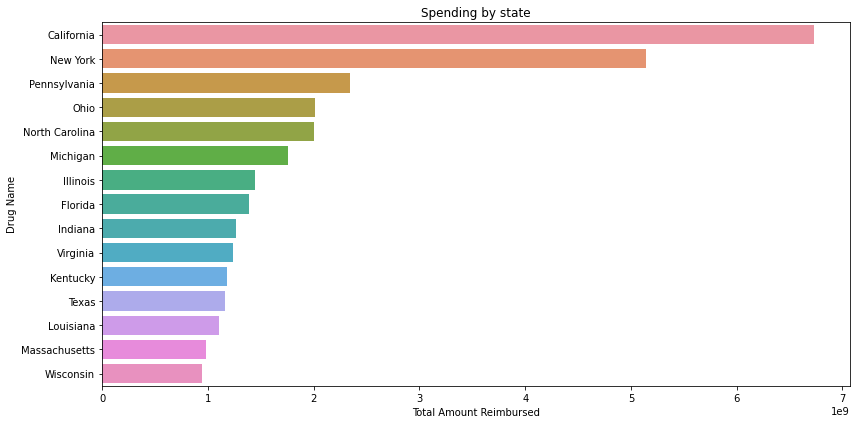

In [259]:
plt.figure(figsize=(12,6))
sns.barplot(data=state_spending_df, x="Total Amount Reimbursed", y="State Full Name")
plt.title("Spending by state")
plt.xlabel("Total Amount Reimbursed")
plt.ylabel("Drug Name")
plt.tight_layout()
plt.show()

In [260]:
# Filtering by the total spending per state
state_usage = (
    df_filtered.groupby("State Full Name")["Units Reimbursed"]
      .sum()
      .sort_values(ascending=False)
      .head(15)
)
state_usage.head(15)


State Full Name
California        2.037401e+09
New York          1.488311e+09
Ohio              7.663352e+08
Pennsylvania      7.039589e+08
Texas             6.490379e+08
North Carolina    5.959167e+08
Michigan          5.167147e+08
Florida           4.880454e+08
Kentucky          4.733878e+08
Illinois          4.474310e+08
Indiana           3.938806e+08
New Jersey        3.557094e+08
Virginia          3.473175e+08
Missouri          3.401117e+08
Massachusetts     3.317646e+08
Name: Units Reimbursed, dtype: float64

In [261]:
# Changing into a dataframe
state_usage_df = state_usage.reset_index()
state_usage_df.columns = ["State Full Name", "Units Reimbursed"]
state_usage_df

,State Full Name,Units Reimbursed
0,California,2.037401e+09
1,New York,1.488311e+09
2,Ohio,7.663352e+08
3,Pennsylvania,7.039589e+08
4,Texas,6.490379e+08
5,North Carolina,5.959167e+08
6,Michigan,5.167147e+08
7,Florida,4.880454e+08
8,Kentucky,4.733878e+08
9,Illinois,4.474310e+08


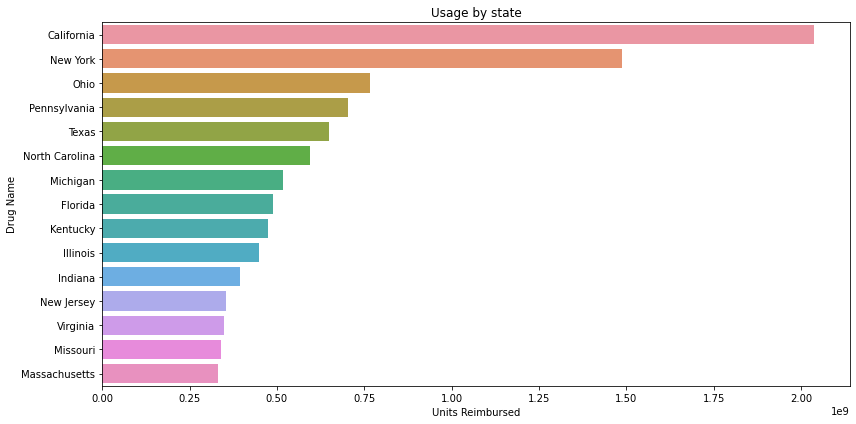

In [262]:
plt.figure(figsize=(12,6))
sns.barplot(data=state_usage_df, x="Units Reimbursed", y="State Full Name")
plt.title("Usage by state")
plt.xlabel("Units Reimbursed")
plt.ylabel("Drug Name")
plt.tight_layout()
plt.show()

In [263]:
df_filtered.duplicated(subset=["State", "Product Name", "Quarter"]).sum()

603682

In [264]:
# Aggregation 
df_model = (
    df_filtered
    .groupby(["State", "Product Name", "Quarter"], as_index=False)
    .agg({
        "Units Reimbursed": "sum",
        "Number of Prescriptions": "sum",
        "Total Amount Reimbursed": "sum",
        "Medicaid Amount Reimbursed": "sum",
        "Non Medicaid Amount Reimbursed": "sum"
    })
)

print("Shape before aggregation:", df_filtered.shape)
print("Shape after aggregation:", df_model.shape)

Shape before aggregation: (641224, 16)
Shape after aggregation: (37542, 8)


In [265]:
df_model["utilization_intensity"] = (
    df_model["Units Reimbursed"] *
    df_model["Number of Prescriptions"]
)

In [274]:
df_model["Product Name"].nunique()

683

Modelling 

In [266]:
df_model["log_spending"] = np.log1p(df_model["Total Amount Reimbursed"])

In [267]:
y = df_model["log_spending"]

X = df_model[["State", "Product Name", "Number of Prescriptions", "Units Reimbursed", "Quarter", "utilization_intensity"]]

In [268]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape


((28156, 6), (9386, 6))

In [275]:
categorical_low = ["State", "Quarter"]      
categorical_high = ["Product Name"]         
numeric_features = ["Units Reimbursed", "Number of Prescriptions", "utilization_intensity"]

In [276]:
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat_low", OneHotEncoder(handle_unknown="ignore"), categorical_low),
        ("cat_high", ce.TargetEncoder(cols=categorical_high), categorical_high),
    ]
)

## Linear Regression

In [277]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

pipeline_lr = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LinearRegression())
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

from sklearn.metrics import mean_absolute_error, r2_score

print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))

Linear Regression MAE: 0.7797522876089817
Linear Regression R2: 0.6503699730140028


Linear Regression was used as a baseline model to estimate log-transformed drug reimbursement spending based on utilization metrics and categorical variables. After aggregating the data and engineering an interaction feature (utilization_intensity), the model achieved an R² of approximately 0.65, explaining about 65% of the variance in spending.

## Ridge 

In [278]:
from sklearn.linear_model import Ridge

pipeline_ridge = Pipeline([
    ("preprocessing", preprocessor),
    ("model", Ridge(alpha=1.0, random_state=42))
])

pipeline_ridge.fit(X_train, y_train)

y_pred_ridge = pipeline_ridge.predict(X_test)

print("Ridge MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("Ridge R2:", r2_score(y_test, y_pred_ridge))

Ridge MAE: 0.7797476709078667
Ridge R2: 0.6503542212395683


Ridge Regression was applied to address potential multicollinearity arising from encoded categorical variables and interaction terms. The model produced nearly identical performance to Linear Regression (R² ≈ 0.65), indicating that regularization did not significantly increase predictive accuracy.

In [279]:
from xgboost import XGBRegressor

pipeline_xgb = Pipeline([
    ("preprocessing", preprocessor),   
    ("model", XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)

print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("XGBoost R2:", r2_score(y_test, y_pred_xgb))

XGBoost MAE: 0.5937251764618964
XGBoost R2: 0.7921798104739077
